# Projet Music Trend Analyser - Python pour la data science

### Auteurs : Nathan SOARES DE MELO & Enrique ALARCON VILLARROEL

L'objectif de ce notebook est d'effectuer une analyse puis une modélisation sur la base de données concernant les 200 chansons les plus populaires du moment. Le projet se déroule en trois phases: 
- <ins>Récupération et traitement des données:</ins> en utilisant le site [Billboard](https://www.billboard.com/charts/billboard-global-200/) pour récupérer les données des 200 chansons les plus populaires du moment, puis les API de MusicBrainz et Genius pour récupérer des informations supplémentaires sur les artistes et les chansons.
- <ins>Analyse des données:</ins> en utilisant des graphiques et des statistiques pour comprendre les tendances et les relations entre les différentes variables.
- <ins>Modélisation:</ins> en utilisant des modèles afin de déterminer d'une part le sentiment général des chansons et d'autre part les paroles les plus populaires.

## Installations préalables

Avant d'exécuter veuillez procéder aux installations de modules nécessaires au bon fonctionnement du code en exécutant la cellule ci-dessous.

In [58]:
#Installations préalables
%pip install lxml
%pip install pandas
%pip install geopandas
%pip install matplotlib
%pip install requests
%pip install bs4
%pip install nltk
%pip install seaborn
%pip install plotly
%pip install tqdm
%pip install pywaffle
%pip install spacy
%pip install plotnine
%pip install great_tables
%pip install wordcloud
%pip install country_converter
%pip install nbformat

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated pa

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\enriq\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python312\\site-packages\\fontawesomefree\\static\\fontawesomefree\\js-packages\\@fortawesome\\fontawesome-free\\svgs\\brands\\creative-commons-sampling-plus.svg'
HINT: This error might have occurred since this system does not have Windows Long Path support enabled. You can find information on how to enable this at https://pip.pypa.io/warnings/enable-long-paths



Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Importation des librairies et des fonctions utiles

In [59]:
import matplotlib.pyplot as plt
import country_converter as coco
import plotly.express as px
import seaborn as sns
import os
from collections import Counter
from wordcloud import WordCloud

%run "src/scripts/billboards.py"
%run "src/scripts/musicbrainz.py"
%run "src/scripts/genius.py"

## Récupération et traitement des données (partie I)

Dans un premier temps, nous récupérons les données du site Billboard en effectuant du scrapping à l'aide des bibliothèques `lxml` et `urllib.request`. Cette étape nous permet de collecter les informations de base sur les 200 chansons les plus populaires du moment. Ces données sont stockées dans un DataFrame `dataframe` qui contient les colonnes suivantes:
- `Song`: le nom de la chanson (string)
- `Artist`: le nom de l'artiste (list of strings)

Les musiques sont ordonnées par popularité, la première musique étant la plus populaire.

In [60]:
dataframe = get_billboard_hits()

# Flatten the list of artists
all_artists = [artist for sublist in dataframe['Artist'] for artist in sublist]

# Count the occurrences of each artist
artist_counts = pd.Series(all_artists).value_counts()

dataframe

,Song,Artist
0,APT.,"[Rosé, Bruno Mars]"
1,All I Want For Christmas Is You,[Mariah Carey]
2,Last Christmas,[Wham!]
3,Die With A Smile,"[Lady Gaga, Bruno Mars]"
4,Rockin' Around The Christmas Tree,[Brenda Lee]
...,...,...
195,Something Just Like This,"[The Chainsmokers, Coldplay]"
196,Dodger Blue,"[Kendrick Lamar, Wallie the Sensei, Siete7x, R..."
197,Counting Stars,[OneRepublic]
198,Lovely,"[Billie Eilish, Khalid]"


On peut dors et déjà faire quelques analyses basiques sur ces données. Par exemple, on peut compter le nombre de fois où chaque artiste apparaît dans le top 200, afin de déterminer les artistes les plus populaires du moment. On remarque alors qu'Ariana Grande et Kendrick Lamar sont les artistes les plus populaires, avec tous les deux 8 chansons dans le top 200. 

<span>&#9888;</span>
**Il est possible que les données récupérées ne soient pas à jour, car elles dépendent du site Billboard qui est fréquemment actualisé.**

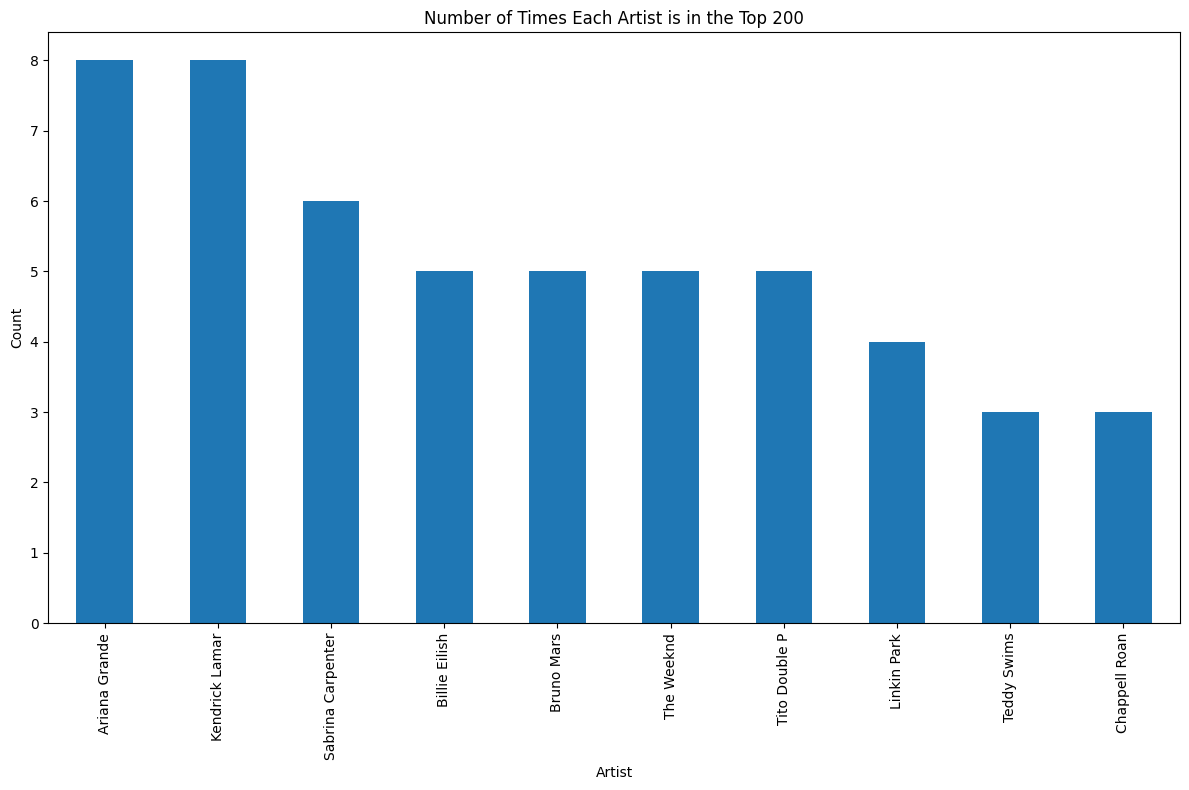

In [61]:
# Plot the data
plt.figure(figsize=(12, 8))
artist_counts.head(10).plot(kind='bar')
plt.title('Number of Times Each Artist is in the Top 200')
plt.xlabel('Artist')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Comme nos données sont pour l'instant trop pauvres pour effectuer une analyse plus poussée, nous allons récupérer des informations supplémentaires sur les artistes et les chansons en utilisant les API de MusicBrainz et Genius.
Dans un premier temps, nous allons récupérer les informations sur les artistes en utilisant l'API de MusicBrainz. Pour cela, nous avons créé une fonction `fetch_artist_data` qui prend en entrée une liste d'artistes et renvoie un DataFrame contenant les informations suivantes:
- `Artist`: le nom de l'artiste (string)
- `Country`: le pays d'origine de l'artiste (string, convention ISO 3166-1 alpha-2 avec 2 lettres)
- `Type`: le type de l'artiste (string, "Person" ou "Group")
- `Gender`: le genre de l'artiste (string)
- `Rating`: le rating de l'artiste (dict, contenant les clés "value" et "votes-count")
- `Tags`: les tags associés à l'artiste (list of dicts, contenant les clés "count" et "name")

Les clés "votes-count" et "count" indique le nombre de fois que les utilisateurs de MusicBrainz ont participé à la notation de l'artiste ou du tag.

<span>&#9432;</span>
**Dans la suite, les données sont directement chargées depuis un fichier csv pour éviter un temps d'attente trop long (environ 10min). Si vous souhaitez tester le script de récupération des données, il suffit de les supprimer du dossier `data` et de relancer le script.**

In [62]:
file_path = 'data/artists_data.csv'
if os.path.exists(file_path):
    df_artists = pd.read_csv(file_path)
    # Convert the 'Rating' column to a dictionary and 'Tags' column to a list
    df_artists['Rating'] = df_artists['Rating'].apply(lambda x: eval(x))
    df_artists['Tags'] = df_artists['Tags'].apply(lambda x: eval(x))
else:
    df_artists = fetch_artist_data(all_artists)
    df_artists.to_csv(file_path, index=False)

df_artists

,Artist,Country,Type,Gender,Rating,Tags
0,ROSÉ,KR,Person,Female,"{'value': 5, 'votes-count': 1}","[{'count': 2, 'name': 'k-pop'}, {'count': 1, '..."
1,Bruno Mars,US,Person,Male,"{'value': 3.75, 'votes-count': 4}","[{'name': '2010s', 'count': 1}, {'count': 4, '..."
2,Mariah Carey,US,Person,Female,"{'votes-count': 13, 'value': 4.4}","[{'count': 1, 'name': '1990s'}, {'count': 1, '..."
3,Wham!,GB,Group,NaN,"{'value': 4.65, 'votes-count': 3}","[{'name': 'christmas music', 'count': 1}, {'na..."
4,Lady Gaga,US,Person,Female,"{'value': 4.25, 'votes-count': 21}","[{'count': 1, 'name': '2000s'}, {'count': 2, '..."
...,...,...,...,...,...,...
251,OneRepublic,US,Group,NaN,"{'votes-count': 3, 'value': 3}","[{'count': 1, 'name': 'folk pop'}, {'count': 3..."
252,Billie Eilish,US,Person,Female,"{'votes-count': 9, 'value': 3.65}","[{'name': '2010s', 'count': 1}, {'count': 1, '..."
253,Khalid,US,Person,Male,"{'votes-count': 0, 'value': None}","[{'name': 'contemporary r&b', 'count': 3}, {'c..."
254,Metro Boomin,US,Person,Male,"{'value': None, 'votes-count': 0}","[{'count': 3, 'name': 'hip hop'}, {'count': 2,..."


Pour nettoyer les données, nous avons simplifié les colonnes `Rating` et `Tags`. Pour la colonne `Rating`, nous l'avons scindée en deux colonnes `RatingValue` et `RatingCount`. Pour la colonne `Tags`, nous avons extrait les noms des tags pour les stocker dans une liste de strings.

In [63]:
# Divide the 'Rating' column in two (value and count)
df_artists['RatingValue'] = df_artists['Rating'].apply(lambda x: x.get('value') if x else None)
df_artists['RatingCount'] = df_artists['Rating'].apply(lambda x: x.get('votes-count') if x else None)

# Remove the 'Rating' column
df_artists.drop(columns=['Rating'], inplace=True)

# Simplify the 'Tags' column (keep only the names)
df_artists['Tags'] = df_artists['Tags'].apply(lambda x: [tag['name'] for tag in x] if x else None)

df_artists

,Artist,Country,Type,Gender,Tags,RatingValue,RatingCount
0,ROSÉ,KR,Person,Female,"[k-pop, korean ballad]",5.00,1
1,Bruno Mars,US,Person,Male,"[2010s, funk, music for soccer moms, pop, r&b,...",3.75,4
2,Mariah Carey,US,Person,Female,"[1990s, 2000s, 90s, adult contemporary, christ...",4.40,13
3,Wham!,GB,Group,NaN,"[christmas music, dance-pop, pop, queer]",4.65,3
4,Lady Gaga,US,Person,Female,"[2000s, 2010s, 2020s, adult contemporary, amer...",4.25,21
...,...,...,...,...,...,...,...
251,OneRepublic,US,Group,NaN,"[folk pop, pop, pop rock, rock]",3.00,3
252,Billie Eilish,US,Person,Female,"[2010s, 2020s, alt-pop, alternative pop, alter...",3.65,9
253,Khalid,US,Person,Male,"[contemporary r&b, hip hop, leftfield, pop, r&...",NaN,0
254,Metro Boomin,US,Person,Male,"[hip hop, trap]",NaN,0


Maintenant, nous souhaitons concaténer les données des artistes avec les données sur le nombre d'apparition dans le top 200. Pour cela, nous utilisons la fonction `merge` de la librairie `pandas` pour fusionner les deux DataFrames sur la colonne `Artist`. Nous pouvons ainsi détecter les artistes mal reconnus par MusicBrainz, car ils n'ont pas de valeur `Count` associée.

De plus, nous en profitons également pour supprimer les doublons dans le DataFrame final, à l'aide de la fonction `drop_duplicates`.

In [64]:
# Merge the two dataframes (df_artists and artist_counts)
df_merged = pd.merge(df_artists, artist_counts, left_on='Artist', right_index=True, how='inner')

# Remove lines with missing values for the 'count' column (remove mismatched artists)
df_merged.dropna(subset=['count'], inplace=True)

# Remove duplicate artists
df_merged.drop_duplicates(subset=['Artist'], inplace=True)

df_merged

,Artist,Country,Type,Gender,Tags,RatingValue,RatingCount,count
1,Bruno Mars,US,Person,Male,"[2010s, funk, music for soccer moms, pop, r&b,...",3.75,4,5
2,Mariah Carey,US,Person,Female,"[1990s, 2000s, 90s, adult contemporary, christ...",4.40,13,2
3,Wham!,GB,Group,NaN,"[christmas music, dance-pop, pop, queer]",4.65,3,1
4,Lady Gaga,US,Person,Female,"[2000s, 2010s, 2020s, adult contemporary, amer...",4.25,21,1
6,Brenda Lee,NaN,Person,Female,"[2008 universal fire victim, american, classic...",4.50,2,1
...,...,...,...,...,...,...,...,...
245,Harry Styles,NaN,Person,Male,"[2020s, funk, new wave, nuno, pop, rock, soft ...",5.00,1,1
246,The Chainsmokers,US,Group,NaN,"[2010s, dance-pop, edm, electro house, electro...",4.50,2,1
250,Roddy Ricch,US,Person,Male,"[english, hip hop, rap, trap]",NaN,0,1
251,OneRepublic,US,Group,NaN,"[folk pop, pop, pop rock, rock]",3.00,3,1


## Analyse descriptive des données (partie I)

Nous avons désormais des données plus complètes. On peut par exemple afficher le nombre de chansons faites par des groupes ou des personnes, ou encore le genre des artistes les plus populaires.

On remarque que la majorité des artistes sont des hommes (qui ne font pas partie d'un groupe).

In [65]:
# Print the number of groups and solo artists
print("Number of groups:", df_merged[df_merged['Type'] == 'Group'].shape[0])
print("Number of solo artists:", df_merged[df_merged['Type'] == 'Person'].shape[0])
print("Percentage of solo artists:", df_merged[df_merged['Type'] == 'Person'].shape[0] / df_merged.dropna(subset=['Type']).shape[0] * 100)

print("====================================")

# Print the number of male and female artists
print("Number of male artists:", df_merged[df_merged['Gender'] == 'Male'].shape[0])
print("Number of female artists:", df_merged[df_merged['Gender'] == 'Female'].shape[0])
print("Percentage of male artists:", df_merged[df_merged['Gender'] == 'Male'].shape[0] / df_merged.dropna(subset=['Gender']).shape[0] * 100)

Number of groups: 31
Number of solo artists: 107
Percentage of solo artists: 77.53623188405797
Number of male artists: 73
Number of female artists: 32
Percentage of male artists: 68.86792452830188


A partir des données récupérées, nous pouvons également afficher un graphique montrant la répartition des artistes par pays. Nous avons utilisé la bibliothèque `plotly.express` pour créer un graphique interactif qui permet de voir le nombre d'artistes par pays en passant la souris sur la carte. Cependant, comme cette librairie utilise une convention ISO-3 pour les pays, nous avons dû convertir les codes ISO-2 en ISO-3 en utilisant la librairie `country_converter` (`coco`).

In [66]:
# Count the number of artists per country
country_counts = df_merged['Country'].value_counts().reset_index()
country_counts.columns = ['Country', 'Count']

cc = coco.CountryConverter()
country_counts['Country'] = country_counts['Country'].apply(lambda x: cc.convert(names=x, to='ISO3'))

# Create a choropleth map
fig = px.choropleth(country_counts, 
                    locations="Country", 
                    locationmode="ISO-3", 
                    color="Count", 
                    hover_name="Country", 
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title="Number of Artists per Country")

fig.show()

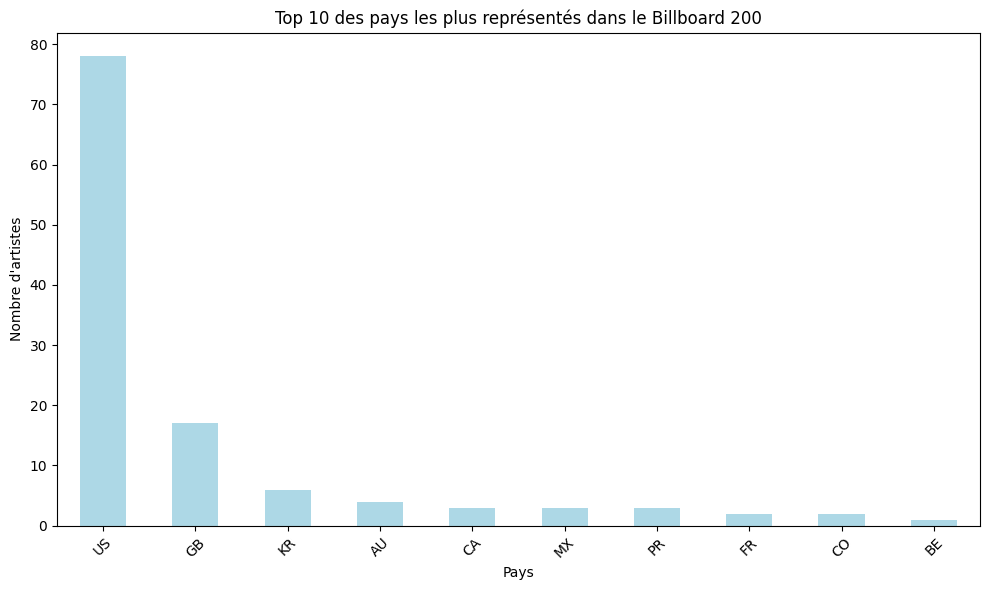

In [67]:
# Les 10 pays les plus représentés
country_counts = df_merged['Country'].value_counts().head(10)  

# Histogramme
plt.figure(figsize=(10, 6))
country_counts.plot(kind='bar', color='lightblue')
plt.title('Top 10 des pays les plus représentés dans le Billboard 200')
plt.xlabel('Pays')
plt.ylabel('Nombre d\'artistes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Nous pouvons également nous intéresser aux notes obtenues par les artistes. Comme on le voit sur le graphique, elles sont globelement très positives, ce qui est cohérent avec le fait que les artistes les plus populaires sont généralement bien notés.

En effet, sur l'axe des abscisses nous représentons les notes obtenues entre 3 et 5 et les fréquences de distribution sur celui des ordonnées. Nous avons également implanté une courbe bleue qui est destinée à illustrer la tendance générale. A première vue, la distribution est asymétrique. Ainsi les notes des artistes figurant dans le classement sont principalement élevées : la majorité des artistes ont des notes comprises entre 3,75 et 5

La note moyenne des artistes du  classement est de 4,3 (avec un écart-type faible de 0,59). Cela signifie que les artistes qui sont classés tendent à être bien notés, et le pic autour de 5 reflète que les artistes obtiennent des notes parfaites (ou presque). En revanche, il y a très peu d'artistes avec des notes inférieures à 3.5 : les artistes les plus mal notés n'atteigent pas le Billboard 200. Cet histogramme permet donc d'établir une forte corrélation entre les notes des artistes et leur succès commercial. 

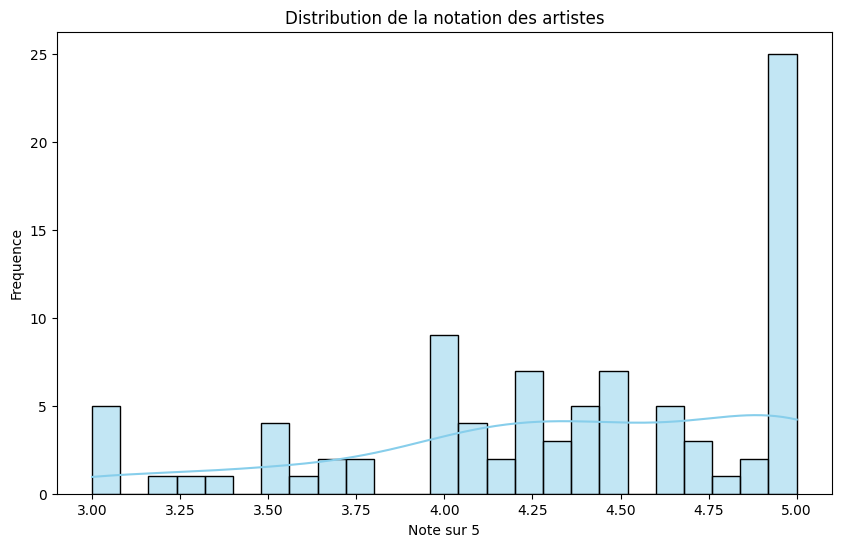

Moyenne de la notation des artistes: 4.344444444444444
Ecart-type de la notation des artistes: 0.5968759702360227


In [88]:
# Histogramme des RatingValue
plt.figure(figsize=(10, 6))
sns.histplot(df_merged['RatingValue'].dropna(), kde=True, bins=25, color='skyblue')
plt.title('Distribution de la notation des artistes')
plt.xlabel('Note sur 5')
plt.ylabel('Frequence')
plt.show()

# Affichage de la moyenne et de l'écart-type
print("Moyenne de la notation des artistes:", df_merged['RatingValue'].mean())
print("Ecart-type de la notation des artistes:", df_merged['RatingValue'].std())



Nous avons vu en début de partie que la majorité des artistes sont des hommes qui ne font pas partie d'un groupe. Rentrons plus en détail dans cette analyse avec visualisation et une représentation graphique des résultats.

Nous avons effectué deux représentations: d'une part un diagramme à barres comparant la fréquence des solistes et des groupes dans les classement, et d'autre part une box plot affichant la distribution des notes pour les deux groupes (avec les notes comprises entre 3 et 5 comme dans l'analyse précédente)

Nous observons que les solistes sont significativement plus nombreux que les groupes dans le Billboard 200: grâce au diagramme à barres nous constatons que la proportion des solistes est environ 3.5 fois plus élevée que celle des groupes. Néanmoins, la boxplot permet d'établir un point commun entre les deux groupes (et donc une caractéristique qu'on a étudié auparavant): les distributions des notes sont très similaires entre les deux types d'artistes. Par conséquent, cette analyse confirme bien (et c'est plutôt rassurant) que la qualité d'une chanson n'est pas liée au fait qu'un artiste la produise individuellement ou avec un groupe. Enfin les artistes solo ont un écart intercartile plus élevé, mais cela est dû au nombre plus élevé des solistes dans le classement. 

Ainsi à travers cette analyse, nous pouvons conclure que l'industrie musicale favorise les artistes solo dans le classement, mais les groupes (en dépit de leur faible nombre par rapport aux solistes) ont dés notes comparables: Ainsi le succès dépend davantage du talent et de la popularité de l'artiste, qu'il soit en solo ou en groupe. S'il y a plus de solistes, c'est probablement dû à des raisons de logistique (plus facile de produire une chason quand on est tout seul, car le choix des chansons dépendent de moins de monde par exemple)

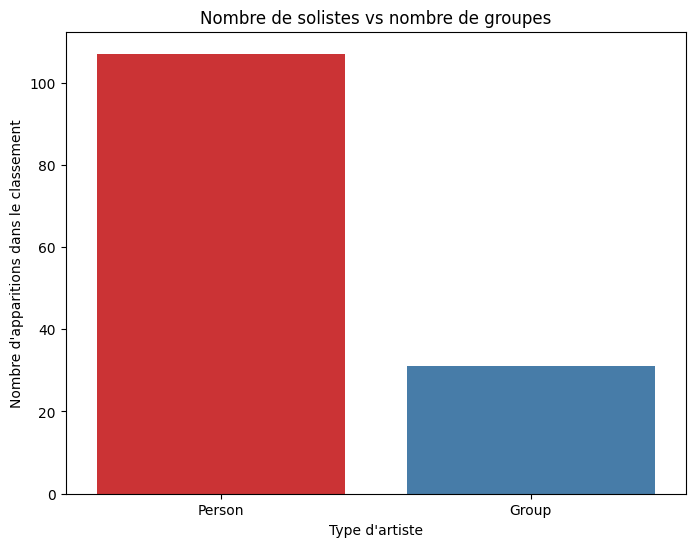

In [69]:
# On compte le nombre de groupes et de solistes
type_counts = df_merged['Type'].value_counts()

# Le diagramme a barres
plt.figure(figsize=(8, 6))
sns.barplot(x=type_counts.index, y=type_counts.values, hue=type_counts.index,  # Assign x to hue
    palette="Set1", dodge=False)
plt.title('Nombre de solistes vs nombre de groupes')
plt.xlabel("Type d'artiste")
plt.ylabel("Nombre d'apparitions dans le classement")
plt.show()


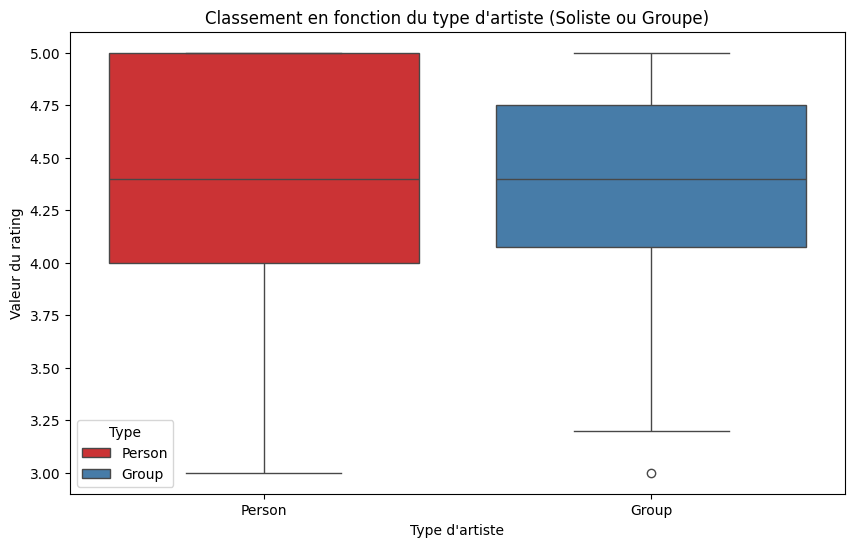

In [70]:
# Box plot pour le type d'artiste
plt.figure(figsize=(10, 6))
sns.boxplot(x='Type', y='RatingValue', data=df_merged, hue='Type', palette="Set1",dodge=False)
plt.title("Classement en fonction du type d'artiste (Soliste ou Groupe)")
plt.xlabel("Type d'artiste")
plt.ylabel('Valeur du rating')
plt.show()


Un raisonnement similaire peut être établi lorsque l'on se penche sur le genre de l'artiste. 

Tout d'abord nous constatons une disparité de genre très marquée dans le classement: parmi les solistes, environ 70% des artistes sont masculins contre 32 pour les femmes et seulement 1-2 artistes non binaires. 

Les boxplots permettent de voir que malgré ce déséquilibre, les répartitions des notes obtenues sont similaires entre les artistes masculines et féminins (moyennes de 4,5 et 4,25 respectivement). D'autre part, les artistes féminines ont une distributions de notes plus concentrée que celle des hommes. 

Nous ne pouvons pas établir de conclusion significative pour les artistes non binaires de par leur faible nombre dans le classement. 

La conclusion est en quelque sorte similaire à l'analyse précédente: la qualité des notes entre les genres les plus réprésentés est comparable. Les hommes sont plus présents dans les classement mais cette surreprésentation n'est pas due à leur qualité en tant qu'artistes. Cela peut s'expliquer par des facteurs externes qui ne sont pas visibles dans les classements: par exemple, les hommes du classement ont probablement plus de contacts, ressoures pour produire leurs chansons- NB: nous ne ferons pas une analyse de ces facteurs parce que cela ne fait pas partie de notre champ de recherche. 

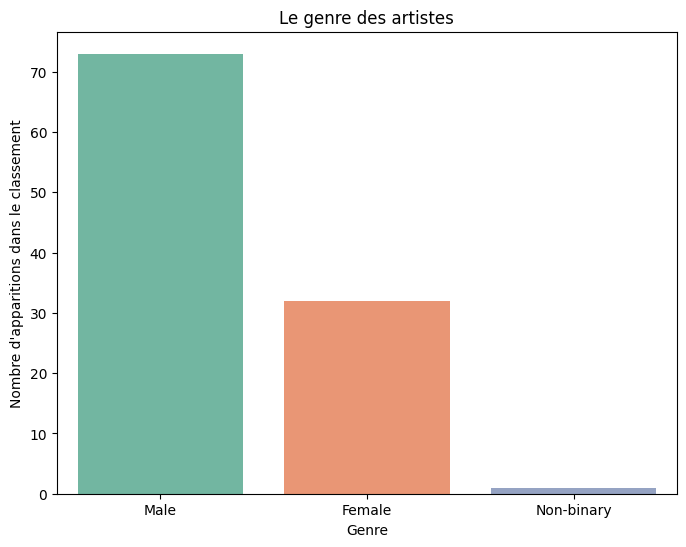

In [71]:
# Le genre des artistes
gender_counts = df_merged['Gender'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=gender_counts.index, y=gender_counts.values, hue=gender_counts.index,palette="Set2", dodge=False)
plt.title('Le genre des artistes')
plt.xlabel('Genre')
plt.ylabel("Nombre d'apparitions dans le classement")
plt.show()


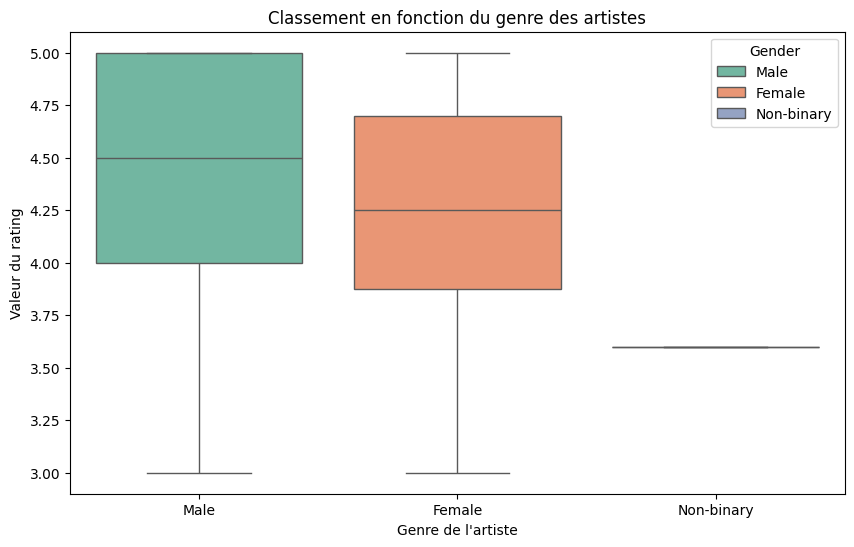

In [90]:
# Box plot pour le genre de l'artist
plt.figure(figsize=(10, 6))
sns.boxplot(x='Gender', y='RatingValue', data=df_merged, hue='Gender', palette="Set2", dodge=False)
plt.title("Classement en fonction du genre des artistes")
plt.xlabel("Genre de l'artiste")
plt.ylabel('Valeur du rating')
plt.show()

## Récupération et traitement des données (partie II)

Pour finir de compléter notre dataset, nous allons récupérer les paroles des chansons en utilisant l'API de Genius. Pour cela, nous avons créé une fonction `fetch_lyrics` qui prend en entrée un DataFrame contenant les chansons et les artistes, et renvoie un DataFrame contenant une nouvelle colonne `Lyrics` qui contient les paroles des chansons.

In [72]:
output_path = 'data/lyrics_data.csv'
if os.path.exists(output_path):
    dataframe = pd.read_csv(output_path)
    # Convert the 'Artist' column to a list
    dataframe['Artist'] = dataframe['Artist'].apply(lambda x: eval(x))
else:
    dataframe = fetch_lyrics(dataframe)
    dataframe.to_csv(output_path, index=False)
    
dataframe

,Song,Artist,Lyrics
0,APT.,"[Rosé, Bruno Mars]",\r\nChaeyoung-iga\r\n joahaneun\r\nRandom game...
1,All I Want For Christmas Is You,[Mariah Carey],\r\nI don't want a lot for Christmas\r\nThere ...
2,Last Christmas,[Wham!],"\r\n\r\nAh, ah-ah\r\nOoh-woah\r\nOh-oh\r\n\r\n..."
3,Die With A Smile,"[Lady Gaga, Bruno Mars]","\r\n\r\n\r\nI, I just woke up from a dream\r\n..."
4,Rockin' Around The Christmas Tree,[Brenda Lee],\r\nRockin' around the Christmas tree\r\nAt th...
...,...,...,...
195,Something Just Like This,"[The Chainsmokers, Coldplay]","\r\nI've been reading books of old, the legend..."
196,Dodger Blue,"[Kendrick Lamar, Wallie the Sensei, Siete7x, R...","\r\nOoh\r\nOoh\r\n\r\nWhite diamonds, 2 a.m., ..."
197,Counting Stars,[OneRepublic],"\r\nLately, I've been, I've been losin' sleep\..."
198,Lovely,"[Billie Eilish, Khalid]",\r\nThought I found a way\r\nThought I found a...


Dans le fichier `src/scripts/nltk_script.py`, nous avons créé une méthode `tokenize_lyrics` qui peut être appliquée à un DataFrame pour tokeniser les paroles des chansons. Cette méthode utilise la librairie `nltk` pour tokeniser les paroles, et plus précisément la méthode `word_tokenize`. Cette méthode permet également de filtrer les stopwords, c'est-à-dire les mots qui n'apportent pas de sens à la phrase (comme "the", "and", "or", etc.).

Depuis `nltk.corpus`, nous avons importé la liste des stopwords en anglais, en français et en espagnol. Nous avons également ajouté quelques mots à la liste des stopwords, car ils apparaissaient fréquemment dans les paroles des chansons et n'apportaient pas de sens à la phrase (comme 'oh', 'na', 'yeah', 'uh', 'ah', etc.).

Ensuite, nous avons pu créer un DataFrame contenant les mots les plus fréquents dans les paroles des chansons. Pour cela, nous avons utilisé la méthode `Counter` de la librairie `collections` pour compter le nombre d'occurrences de chaque mot dans les paroles. Nous avons ensuite affiché les 20 mots les plus fréquents dans les paroles des chansons.

In [73]:
%run "src/scripts/nltk_script.py"

# Tokenize the lyrics
dataframe['LyricsTokenized'] = dataframe['Lyrics'].apply(tokenize_lyrics)

# Count the occurrences of each word
word_counts = Counter([word for sublist in dataframe['LyricsTokenized'] for word in sublist])

# Print the most common words
word_counts.most_common(20)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\enriq\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\enriq\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\enriq\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('like', 494),
 ('know', 341),
 ('christmas', 317),
 ('love', 313),
 ('baby', 293),
 ('got', 255),
 ('wan', 249),
 ('get', 236),
 ('let', 198),
 ('one', 180),
 ('want', 177),
 ('say', 170),
 ('nigga', 169),
 ('make', 168),
 ('tell', 163),
 ('way', 161),
 ('see', 160),
 ('go', 156),
 ('come', 151),
 ('time', 144)]

## Analyse descriptive des données (partie II)

Dans cette partie, nous allons mener une analyse fréquentielle des paroles des chansons du classement Billboard 200. Pour ce faire, nous avons mobilisé deux approches complémentaires en appliquant les bibliothèques `NLTK` et `spaCy`.

La première (`NLTK`), dont l'utilisation a débuté dans la partie précédente, met l'accent sur le nettoyage et l'épuration des paroles. Elle permet de dégager facilement les stopwords (en anglais, français et espagnol, ainsi que les interjections) afin d'obtenir une première vue d'ensemble sur les mots les plus fréquents. Cette méthode permet d'établir les thèmes principaux présents dans les paroles et sera très utile pour la partie suivante (en lien avec l'analyse des sentiments).

La deuxième (`spaCy`) se distingue par sa capacité à intégrer toutes les données textuelles sous forme de tokens (y compris les interjections). Pour faciliter le travail, nous avons conservé uniquement l'étude des mots en anglais (notamment parce que c'est la langue la plus représentée dans le classement). Ainsi, en exploitant le modèle `en_core_web_sm`, nous sommes parvenus à nettoyer et capturer les tokens afin d'enrichir l'analyse fréquentielle et aboutir à une première tentative de mise en relation avec les mots (avec l'approche bag-of-words).

Nous pouvons désormais représenter les mots les plus fréquents dans les paroles des chansons en utilisant un nuage de mots. Pour cela, nous avons utilisé la librairie `wordcloud` pour créer un nuage de mots qui permet de visualiser les mots les plus fréquents dans les paroles des chansons. Plus un mot est fréquent, plus il est grand dans le nuage de mots.

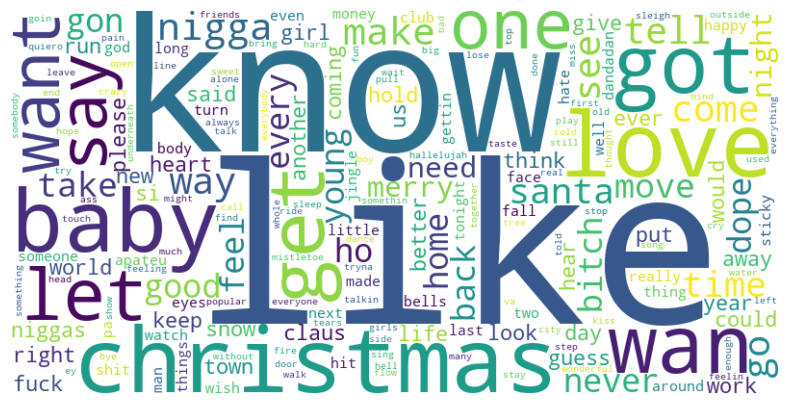

In [74]:
# Generate a word cloud

wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(word_counts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

D'après l'étude précédente, les mots qui ressortent le plus sont "love", "like", "know" et "baby". On peut interpréter ceci comme suit :

Tout d'abord, concernant les thèmes principaux :
- La dominance de "love" et de "baby" souligne la présence de thèmes romantiques dans la musique populaire.
- Les mots du langage courant (mots béquilles) comme "know" ou "like" reflètent la volonté des artistes de rendre leurs paroles accessibles afin que le plus grand nombre de personnes puisse s'y identifier (d'où leur présence dans le classement).
- La présence de mots issus de l'argot tels que "bitch", "nigga", "fuck" montre l'influence du rap dans le classement ainsi que la tolérance de ces mots de la part du public.
- Enfin, compte tenu de la saison, le mot "Christmas" est présent.

Le choix de ces mots n'est pas anodin : le style informel et accessible semble captiver davantage  les auditeurs

Passons maintenant à l'analyse fréquentielle avec `spaCy`. 
Tout d'abord nous créons deux fonctions `tokenize_lyrics` et `clean_tokens` pour convertir les paroles en tokens et par la suite les nettoyer. La deuxième fonction s'avère très utile parce que en observant la colonne `Tokens` du dataframe `df_freq_analysis`, nous pouvons constater la présence des caractères au début de plusieurs tokens (comme "\n" ou "\n\n") qui polluent notre analyse


In [ ]:
#Tokenization et nettoyage des paroles avec spaCy
#Le cadre
import spacy
!python -m spacy download en_core_web_sm
nlp_english = spacy.load("en_core_web_sm")

#tokenisation
def tokenize_lyrics(lyrics):
    doc = nlp_english(lyrics)  
    tokens = [token.text for token in doc]  
    return tokens

df_freq_analysis=dataframe.copy()
df_freq_analysis['Tokens'] = df_freq_analysis['Lyrics'].apply(tokenize_lyrics)


#Nettoyage
import string
def clean_tokens(tokens):
    cleaned_tokens=[]
    for token in tokens:
        token = token.strip()  
        if token not in {"\n", "\n\n", "\n\n\n"} and token not in string.punctuation: 
            cleaned_tokens.append(token.lower())
    return cleaned_tokens
df_freq_analysis

df_freq_analysis['Cleaned_Tokens'] = df_freq_analysis['Tokens'].apply(clean_tokens)


Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
     - -------------------------------------- 0.5/12.8 MB 1.2 MB/s eta 0:00:11
     --- ------------------------------------ 1.0/12.8 MB 1.5 MB/s eta 0:00:08
     ---- ----------------------------------- 1.3/12.8 MB 1.6 MB/s eta 0:00:08
     ---- ----------------------------------- 1.6/12.8 MB 1.6 MB/s eta 0:00:08
     ------ --------------------------------- 2.1/12.8 MB 1.6 MB/s eta 0:00:07
     ------- -------------------------------- 2.4/12.8 MB 1.6 MB/s eta 0:00:07
     --------- ------------------------------ 2.9/12.8 MB 1.6 MB/s eta 0:00:07
     --------- ------------------------------ 3.1/12.8 MB 1.6 MB/s eta 0:00:06
     ---------- ----------------------------- 3.4/12.8 MB 1.6 MB/s eta 0:0

In [76]:
#Détermination de la durée moyenne des chansons (en termes de mots)
df_freq_analysis['Cleaned_Tokens_Count'] = df_freq_analysis['Cleaned_Tokens'].apply(len)
average_count=df_freq_analysis['Cleaned_Tokens_Count'].mean()
print(f"Le nombre moyen de mots par chanson est {average_count:.2f}")


Le nombre moyen de mots par chanson est 364.17


Nous avons divisé l'analyse fréquentielle avec spaCy en deux parties.
Dans la première partie, nous avons mené une analyse sans filtre, incluant absolument tous les mots des paroles. Cela nous permet de compléter l'analyse effectuée avec `NLTK` et d'identifier le type d'approche privilégié par les artistes.

En effet, en regardant l'histogramme et le word cloud suivants, nous remarquons que les paroles sont dominées par les pronoms ("I" : environ 3 200 occurrences, "you" : environ 2 000 occurrences). Cette fréquence élevée est liée à la thématique de l'amour abordée précédemment : les artistes populaires adoptent une approche très personnelle et conversationnelle, cherchant à se rapprocher de leur public en adoptant leur point de vue. Les autres mots, comme les prépositions, reflètent également le caractère accessible des paroles.

    Word  Frequency
16     i       3238
39   you       2408
57   the       2019
64     a       1431
32    me       1294
59    it       1252
127  and       1106
12    to       1093
26    's        936
38   n't        874


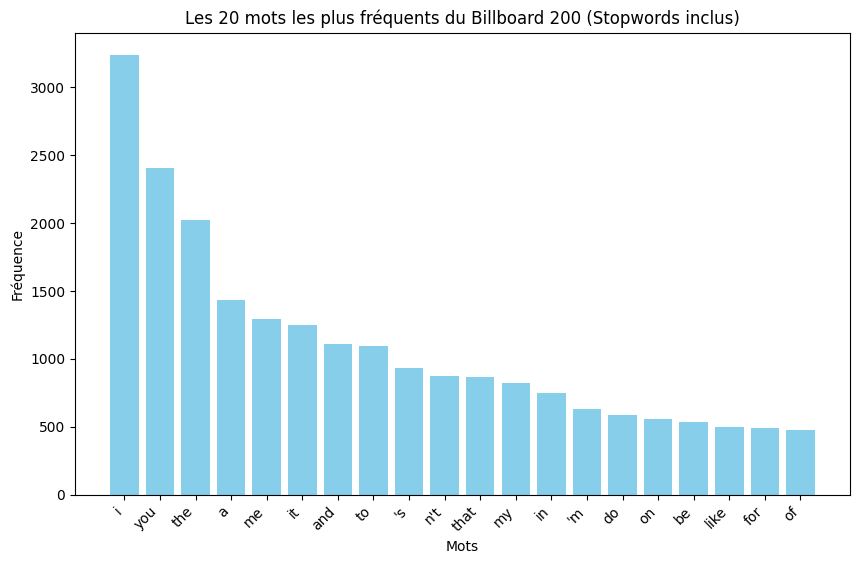

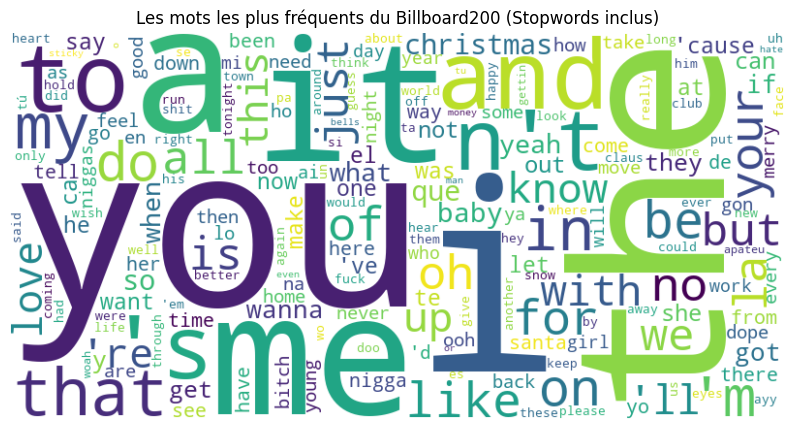

In [ ]:
#Analyse fréquentielle: Recherche des thématiques principales et des mots les plus récurrents (1/2) 

# 1) Tout d'abord on fait une analyse sans filtre (on n'élimine pas les stopwords)
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Pour faciliter l'analyse, on cree une Series qui regroupe tous les mots de toutes les chansons
all_words = [word for tokens in df_freq_analysis['Cleaned_Tokens'] for word in tokens]

# Nous allons établir la fréquence d'apparition des mots les plus fréquents dans le Billboard200
word_counts = Counter(all_words)
freq_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)
print(freq_df.head(10))

# Création d'un histogramme
top_n = 20  # Rq: on pourra librement modifier ce nombre
top_words = freq_df.head(top_n)

plt.figure(figsize=(10, 6))
plt.bar(top_words['Word'], top_words['Frequency'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title(f'Les {top_n} mots les plus fréquents du Billboard 200 (Stopwords inclus)')
plt.xlabel('Mots')
plt.ylabel('Fréquence')
plt.show()

# Création d'un wordcloud
wordcloud_lyrics = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_lyrics, interpolation='bilinear')
plt.axis('off')
plt.title('Les mots les plus fréquents du Billboard200 (Stopwords inclus)')
plt.show()



Dans la deuxième partie de l'analyse, nous obtenons des résultats similaires à ceux trouvés avec `NLTK`, notamment les mots "love", "baby" et "like". Cependant, l'analyse avec `spaCy` met également en évidence des interjections supplémentaires, telles que "oh" (463 occurrences), "la" (446 occurrences) et "yeah" (266 occurrences), qui n'ont pas été classées comme stopwords. Ces interjections jouent un rôle clé en renforçant l'expressivité des paroles et en contribuant au rythme des chansons, un aspect essentiel puisqu'elles s'intègrent harmonieusement aux mélodies.

           Word  Frequency
25         like        497
23           oh        463
163          la        446
48         know        341
134        love        318
56    christmas        317
1130        que        312
26         baby        295
19         yeah        266
32          got        255


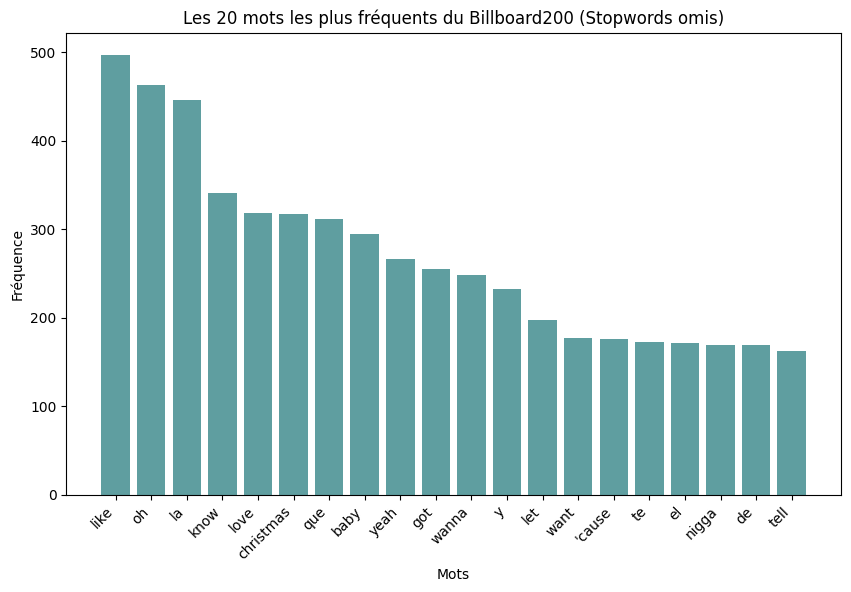

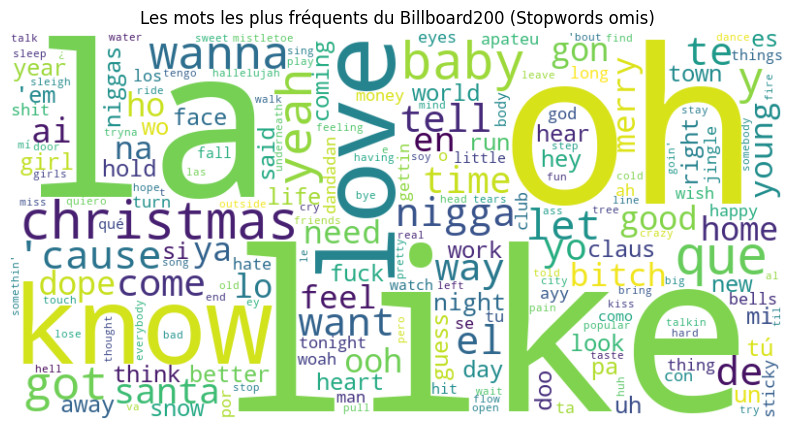

In [92]:
#Analyse fréquentielle: Recherche des thématiques principales et des mots les plus récurrents (2/2) 

# 2) Nous allons éliminer les stopwords afin de pouvoir déterminer les thématiques les plus présentes dans le Billboard 200. 

stop_words_english = nlp_english.Defaults.stop_words 
all_words_filtered = [word for word in all_words if word.lower() not in stop_words_english]

#Et on procède comme à l'étape précédente
word_counts_filtered = Counter(all_words_filtered)
freq_df_filtered = pd.DataFrame(word_counts_filtered.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)
print(freq_df_filtered.head(10))

# Création d'un histogramme
top_n = 20  #Rq: on pourra librement modifier ce nombre
top_words_filtered = freq_df_filtered.head(top_n)

plt.figure(figsize=(10, 6))
plt.bar(top_words_filtered['Word'], top_words_filtered['Frequency'], color='cadetblue')
plt.xticks(rotation=45, ha='right')
plt.title(f'Les {top_n} mots les plus fréquents du Billboard200 (Stopwords omis)')
plt.xlabel('Mots')
plt.ylabel('Fréquence')
plt.show()

# Création d'un wordcloud
wordcloud_lyrics_filtered = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts_filtered)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_lyrics_filtered, interpolation='bilinear')
plt.axis('off')
plt.title('Les mots les plus fréquents du Billboard200 (Stopwords omis)')
plt.show()



Enfin nous procédons à l'analyse par lemmatisation qui permet d'affiner les résultats précédents, afin d'avoir une vision plus précise de la fréquences de certains thèmes dans le classement du Billboard_200. 

Un détail survient: nous remarquons la présence de mots en Espagnol comme "de", "te" ou "el", vu que nous avons uniquement travaillé avec `en_core_web_sm`, les stopwords en Espagnol n'ont pas été éliminés. Néanmoins cela met en évidence une tendance: la présence importante es artistes hispaniques dans les classements en tant que solistes ou en tant que collaborateurs d'autres artistes.

De plus, le thème du désir et de l'intention est plus présent (par exemple en additionnant les occurrences de wanna et want).
Finalement, les verbes d'action comme "come", "tell" et "let" deviennent plus visibles.
 

In [79]:
#Lemmatization (utile pour l'approche bag-of-words)
def lemmatize_tokens(tokens):
    doc=nlp_english(" ".join(tokens))
    lemmatized_tokens = [token.lemma_ for token in doc if not token.is_stop]
    return lemmatized_tokens

#Lemmatization des Series all_words et all_words_filtered
all_words_lemmatized = lemmatize_tokens(all_words)
all_words_filtered_lemmatized = lemmatize_tokens(all_words_filtered)

df_freq_analysis['Lemmas'] = df_freq_analysis['Cleaned_Tokens'].apply(lemmatize_tokens)



In [80]:
#Un dernier graphique: Les 25 "lemmas" les plus récurrents dans le BillBoard200
lemma_counter = Counter(all_words_filtered_lemmatized)
sorted_lemma_counts = lemma_counter.most_common(25)
sorted_lemma_counts_df = pd.DataFrame(sorted_lemma_counts, columns=["Mot", "Nombre d'occurrences"])

# Visualisation: barres pour la représentation des fréquences
def occurrences_bar_graph(data, column):
    max_value = data[column].max()
    bars = data[column].apply(lambda x: f"<div style='width: {x/max_value*100}%; height: 20px; background-color: green;'></div>")
    return bars

sorted_lemma_counts_df["Barre"] = occurrences_bar_graph(sorted_lemma_counts_df, "Nombre d'occurrences")

# Affichage
from IPython.display import display, HTML
display(HTML(sorted_lemma_counts_df.to_html(escape=False, index=False)))


Mot,Nombre d'occurrences,Barre
like,499,
oh,463,
la,446,
know,381,
love,337,
christmas,321,
que,312,
baby,296,
get,280,
come,272,


Ainsi, nous pouvons conclure, en mêlant toutes les analyses précédentes, que :

- Certaines chansons sont populaires en raison des effets saisonniers : en cette période de fin d'année, "Christmas" est un mot très fréquent.
- Les artistes adoptent une approche sentimentale en mettant en avant leur point de vue (omniprésence du "I" dans les chansons).
- Les mots sont simples pour attirer le plus grand nombre d'auditeurs (simples en termes de vocabulaire, ou en utilisant des interjections pour jouer avec les mélodies). À cela s'ajoutent les mots d'argot en anglais.
- Les thèmes de l'amour, du désir et les verbes d'action sont les plus importants dans le classement.
- L'augmentation des artistes hispaniques et la présence de l'Espagnol dans les chansons les plus populaires deviennent de plus en plus importants. 

## Modélisation

Dans un premier temps, intéressons-nous à la prédiction du sentiment général des chansons. Pour cela, nous allons utiliser un modèle de classification pré-entraîné provenant de la librairie `nltk.sentiment.vader`. Ce modèle permet de prédire le sentiment général d'un texte en lui attribuant une note entre -1 (négatif) et 1 (positif). Nous allons appliquer ce modèle aux paroles des chansons pour prédire le sentiment général de chaque chanson.

In [82]:
# Analyze the sentiment of the lyrics
dataframe['Sentiment'] = dataframe['LyricsTokenized'].apply(analyze_sentiment)

# Divide the sentiment into positive, negative, and neutral
dataframe['Positive'] = dataframe['Sentiment'].apply(lambda x: x['pos'])
dataframe['Negative'] = dataframe['Sentiment'].apply(lambda x: x['neg'])
dataframe['Neutral'] = dataframe['Sentiment'].apply(lambda x: x['neu'])

# Remove the 'Sentiment' column
dataframe.drop(columns=['Sentiment'], inplace=True)

dataframe

,Song,Artist,Lyrics,LyricsTokenized,Positive,Negative,Neutral
0,APT.,"[Rosé, Bruno Mars]",\r\nChaeyoung-iga\r\n joahaneun\r\nRandom game...,"[joahaneun, random, game, random, game, game, ...",0.206,0.053,0.741
1,All I Want For Christmas Is You,[Mariah Carey],\r\nI don't want a lot for Christmas\r\nThere ...,"[want, lot, christmas, one, thing, need, care,...",0.327,0.000,0.673
2,Last Christmas,[Wham!],"\r\n\r\nAh, ah-ah\r\nOoh-woah\r\nOh-oh\r\n\r\n...","[last, christmas, gave, heart, next, day, gave...",0.308,0.128,0.564
3,Die With A Smile,"[Lady Gaga, Bruno Mars]","\r\n\r\n\r\nI, I just woke up from a dream\r\n...","[woke, dream, say, goodbye, know, means, since...",0.317,0.160,0.523
4,Rockin' Around The Christmas Tree,[Brenda Lee],\r\nRockin' around the Christmas tree\r\nAt th...,"[rockin, around, christmas, tree, christmas, p...",0.392,0.023,0.585
...,...,...,...,...,...,...,...
195,Something Just Like This,"[The Chainsmokers, Coldplay]","\r\nI've been reading books of old, the legend...","[reading, books, old, legends, myths, achilles...",0.429,0.050,0.521
196,Dodger Blue,"[Kendrick Lamar, Wallie the Sensei, Siete7x, R...","\r\nOoh\r\nOoh\r\n\r\nWhite diamonds, 2 a.m., ...","[white, diamonds, 2, wildin, bitches, sick, go...",0.087,0.326,0.587
197,Counting Stars,[OneRepublic],"\r\nLately, I've been, I've been losin' sleep\...","[lately, losin, sleep, dreamin, things, could,...",0.071,0.103,0.826
198,Lovely,"[Billie Eilish, Khalid]",\r\nThought I found a way\r\nThought I found a...,"[thought, found, way, thought, found, way, nev...",0.225,0.155,0.620


In [83]:
# Mean of the sentiment scores
print(dataframe[['Positive']].mean())
print(dataframe[['Negative']].mean())
print(dataframe[['Neutral']].mean())

# Display the saddest song
saddest_song = dataframe.loc[dataframe['Negative'].idxmax()]
print("Saddest song:", saddest_song['Song'] + " by " + saddest_song['Artist'][0])
print("Score:", saddest_song['Negative'])

# Display the happiest song
happiest_song = dataframe.loc[dataframe['Positive'].idxmax()]
print("Happiest song:", happiest_song['Song'] + " by " + happiest_song['Artist'][0])
print("Score:", happiest_song['Positive'])

Positive    0.23738
dtype: float64
Negative    0.11674
dtype: float64
Neutral    0.64586
dtype: float64
Saddest song: Ma Meilleure Ennemie by Stromae
Score: 0.448
Happiest song: Merry Christmas by Ed Sheeran
Score: 0.646


In [84]:
# Word embedding and visualization
import spacy

# Load the pre-trained model
nlp = spacy.load('en_core_web_md')

# Get the vector for the first 100 words
vectors = [nlp(word).vector for word in list(word_counts.keys())[:50]]

# Reduce the dimensionality of the vectors
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(vectors)

# Create a dataframe
df_vectors = pd.DataFrame(vectors_2d, columns=['x', 'y'])
df_vectors['word'] = list(word_counts.keys())[:50]

# Plot the words with their labels
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_vectors, x='x', y='y')
for i, word in df_vectors.iterrows():
    plt.text(word['x'], word['y'], word['word'])
plt.title('Word Embedding')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

OSError: [E050] Can't find model 'en_core_web_md'. It doesn't seem to be a Python package or a valid path to a data directory.

In [38]:
# For each song, put the five most common words in a list and add them to the dataframe
dataframe['TopWords'] = dataframe['LyricsTokenized'].apply(lambda x: [word for word, count in Counter(x).most_common(5)])

dataframe


,Song,Artist,Lyrics,LyricsTokenized,Positive,Negative,Neutral,TopWords
0,APT.,"[Rosé, Bruno Mars]",\nChaeyoung-iga\n joahaneun\nRandom game\nRand...,"[joahaneun, random, game, random, game, game, ...",0.206,0.053,0.741,"[apateu, like, want, need, meet]"
1,All I Want For Christmas Is You,[Mariah Carey],\nI don't want a lot for Christmas\nThere is j...,"[want, lot, christmas, one, thing, need, care,...",0.317,0.000,0.683,"[want, christmas, baby, wo, make]"
2,Last Christmas,[Wham!],"\n\nAh, ah-ah\nOoh-woah\nOh-oh\n\nLast Christm...","[last, christmas, gave, heart, next, day, gave...",0.308,0.128,0.564,"[someone, give, gave, heart, special]"
3,Die With A Smile,"[Lady Gaga, Bruno Mars]","\n\n\nI, I just woke up from a dream\nWhere yo...","[woke, dream, say, goodbye, know, means, since...",0.317,0.160,0.523,"[wan, next, world, ending, night]"
4,Rockin' Around The Christmas Tree,[Brenda Lee],\nRockin' around the Christmas tree\nAt the Ch...,"[rockin, around, christmas, tree, christmas, p...",0.392,0.023,0.585,"[christmas, rockin, around, tree, let]"
...,...,...,...,...,...,...,...,...
195,Something Just Like This,"[The Chainsmokers, Coldplay]","\nI've been reading books of old, the legends ...","[reading, books, old, legends, myths, achilles...",0.429,0.050,0.521,"[something, want, like, wan, somebody]"
196,Dodger Blue,"[Kendrick Lamar, Wallie the Sensei, Siete7x, R...","\nOoh\nOoh\n\nWhite diamonds, 2 a.m., she wild...","[white, diamonds, 2, bitches, sick, got, stoma...",0.086,0.325,0.589,"[walk, bitch, know, first, might]"
197,Counting Stars,[OneRepublic],"\nLately, I've been, I've been losin' sleep\nD...","[lately, losin, sleep, dreamin, things, could,...",0.071,0.103,0.826,"[countin, could, burn, river, money]"
198,Lovely,"[Billie Eilish, Khalid]",\nThought I found a way\nThought I found a way...,"[thought, found, way, thought, found, way, nev...",0.218,0.150,0.632,"[ca, place, mind, hello, welcome]"


In [39]:
# For each tag, find the most common words
tag_words = []
for tag in df_merged['Tags']:
    if tag:
        for word in tag:
            if word not in tag_words:
                tag_words.append(word)
                
print(tag_words)
print(df_merged['Tags'])
                    
# For each tag, find the artists, then the songs, then the most common words
most_common_words = {}
for tag in tag_words:
    artists = df_merged[df_merged['Tags'].apply(lambda x: x is not None and tag in x)]['Artist']
    songs = dataframe[dataframe['Artist'].apply(lambda x: any(artist in x for artist in artists))]['LyricsTokenized']
    words = [word for sublist in songs for word in sublist]
    most_common_words[tag] = Counter(words).most_common(5)
    
most_common_words

['2010s', 'funk', 'music for soccer moms', 'pop', 'r&b', 'relic inn', 'rock', 'soul', '1990s', '2000s', '90s', 'adult contemporary', 'christmas music', 'contemporary r&b', 'dance-pop', 'easy listening', 'english', 'hip hop', 'pop soul', 'quiet storm', 'queer', '2020s', 'americana', 'dance', 'electro house', 'electronic', 'electropop', 'film soundtrack', 'jazz', 'late 2000s', 'pop rock', 'synth-pop', 'synthpop', '2008 universal fire victim', 'american', 'classic pop and rock', 'country', 'rock and roll', 'rockabilly', 'alt-pop', 'alternative pop', 'alternative r&b', 'art pop', 'bedroom pop', 'dark pop', 'indie pop', 'pity pop', 'singer-songwriter', 'trap soul', 'folk pop', 'big band', 'country pop', 'standards', 'traditional pop', 'vocal jazz', 'alternative hip hop', 'conscious hip hop', 'hardcore hip hop', 'jazz rap', 'pop rap', 'rap', 'trap', 'west coast hip hop', 'hip hop soul', 'neo soul', 'easy listening soundtracks and musicals', 'australian', 'baroque pop', 'brill building', 'gir

{'2010s': [('like', 106),
  ('love', 83),
  ('baby', 80),
  ('know', 63),
  ('apateu', 59)],
 'funk': [('apateu', 59),
  ('like', 43),
  ('know', 17),
  ('wan', 17),
  ('want', 15)],
 'music for soccer moms': [('apateu', 59),
  ('like', 55),
  ('come', 45),
  ('love', 35),
  ('baby', 29)],
 'pop': [('like', 280),
  ('baby', 202),
  ('know', 201),
  ('love', 170),
  ('get', 153)],
 'r&b': [('like', 89),
  ('baby', 73),
  ('know', 62),
  ('apateu', 59),
  ('sticky', 59)],
 'relic inn': [('apateu', 59),
  ('like', 50),
  ('want', 16),
  ('wan', 14),
  ('way', 13)],
 'rock': [('like', 103),
  ('christmas', 69),
  ('apateu', 59),
  ('know', 59),
  ('sticky', 59)],
 'soul': [('like', 69),
  ('apateu', 59),
  ('baby', 46),
  ('want', 45),
  ('know', 38)],
 '1990s': [('bye', 33),
  ('baby', 29),
  ('christmas', 19),
  ('wan', 17),
  ('want', 16)],
 '2000s': [('sticky', 59),
  ('baby', 54),
  ('gettin', 39),
  ('wan', 36),
  ('want', 35)],
 '90s': [('bye', 33),
  ('baby', 29),
  ('christmas', 1

Régression linéaire-tentative

In [85]:
#Installation préalable
%pip install scikit-learn

# On crée une fonction pour mettre en place les covariables visant à prédire Y (ici: la position dans le classement du Billboard 200)
def prepare_data(dataframe,df_freq_analysis,df_merged):
    df_freq_analysis_bis=df_freq_analysis.copy()
    df_freq_analysis_bis['Artist'] = df_freq_analysis['Artist'].apply(
    lambda x: x[0] if isinstance(x, list) and len(x) > 0 else x)

    #Juxtaposition caractéristiques artistes et chansons
    artist_features = df_merged[['Artist', 'Type', 'Gender', 'Country', 'RatingValue']]
    df_regression = pd.merge(df_freq_analysis_bis, artist_features, on='Artist', how='left')
    df_regression = df_regression.rename(columns={'Cleaned_Tokens_Count': 'SongLength'}) 

    #Ajout de l'analyse de l'étude des sentiments
    sentiment_analysis=dataframe[['Artist','Positive','Negative','Neutral']]
    sentiment_analysis['Artist'] = df_freq_analysis['Artist'].apply(
    lambda x: x[0] if isinstance(x, list) and len(x) > 0 else x)
    df_regression = pd.merge(df_regression, sentiment_analysis, on='Artist', how='left')
    df_regression['DominantEmotion'] = df_regression[['Positive', 'Negative', 'Neutral']].idxmax(axis=1)

    #Ajout de la thématique principale // ici on peut essayer de rajouter une colonne avec la "thématique principale", mais pour l'instant je n'ai pas réussi

    #Filtration: nous n'allons conserver que les colonnes qui nous intéressent pour la régression (sélection des covariables)
    df_regression_filtered=df_regression[['Type','Gender','Country','RatingValue','SongLength','DominantEmotion','Positive', 'Negative', 'Neutral']]
    df_regression_filtered=df_regression_filtered.dropna()
    df_regression_filtered= df_regression_filtered.reset_index(drop=True)

    return df_regression_filtered

prepare_data(dataframe,df_freq_analysis,df_merged)
df_regression_filtered=prepare_data(dataframe,df_freq_analysis,df_merged)


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


C:\Users\enriq\AppData\Local\Temp\ipykernel_22800\3360713027.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\enriq\AppData\Local\Temp\ipykernel_22800\3360713027.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [86]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
    
''' 
Nous allons créer une fonction qui va entraîner un modèle de régression pour pouvoir prédire les
classements du Billboard 200, pour cela nos allons utiliser df_regression filtered, et on veut que 
le modèle retourne les valeurs prédites et réelles pour faire une comparaison, ainsi que le MSE et le R2 pour déterminer 
si le modèle est adapté ou pas.
'''

def train_model(df_regression_filtered):
       
    # Définition des features (covariables) et de la variable à prédire
    X = df_regression_filtered[['Type', 'Gender', 'Country', 'RatingValue', 'SongLength', 'DominantEmotion', 'Positive', 'Negative', 'Neutral']]
    y = df_regression_filtered.index + 1  # pour que les classements commencent à 1

    # Division des données en ensembles d'entraînement et de test ( 80 % pour l’entraînement (train) et 20 % pour le test (test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # pour la reproductibilité

    # Préprocesseur pour séparer les colonnes catégoriques et numériques
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), ['Type', 'Gender', 'Country', 'DominantEmotion']),
            ('num', StandardScaler(), ['RatingValue', 'SongLength', 'Positive', 'Negative', 'Neutral'])
        ]
    )

    # Juxtaposition du préprocesseur et du modèle de régression
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])

    # Entraînement du modèle, à la suite du prétraitement
    model_pipeline.fit(X_train, y_train)

    # Évaluation du modèle
    y_pred = model_pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return model_pipeline, mse, r2, y_test, y_pred

model, mse, r2, y_test, y_pred = train_model(df_regression_filtered)
print(f"MSE: {mse:.2f}, R²: {r2:.2f}")


MSE: 5434.90, R²: -0.01


Les résultats sont très décevants.
- Le R2 est carrément négatif et la MSE élevée indique que les prédictions sont très éloignées des valeurs réelles. 

Ces résultats peuvent s'expliquer par
- probablement les caractéristiques que nous avons choisis comme covariables: ces dernières peuvent ne pas être pertinentes pour établir le modèle de prédiction
- ou encore des données insuffisantes ou bruités: il faut garder en tête que nous avons un échantillon assez petit, ce qui peut avoir un impact sur le résultat de la prédiction.

Par exemple, dans la pipeline, on peut utiliser le GradientBoostingRegressor (qui remplace donc la régression linéaire) pour capturer les relations non linéaires entre la variable et les covariables. Ce modèle qui  combine plusieurs arbres de décisions afin d'améliorer les performances.

In [87]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

def train_model_2(df_regression_filtered):
    
    X = df_regression_filtered[['Type', 'Gender', 'Country', 'RatingValue', 'SongLength', 'DominantEmotion', 'Positive', 'Negative', 'Neutral']]
    y = df_regression_filtered.index + 1  # Classements, supposant un index commençant à 1

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), ['Type', 'Gender', 'Country', 'DominantEmotion']),
            ('num', StandardScaler(), ['RatingValue', 'SongLength', 'Positive', 'Negative', 'Neutral'])
        ]
    )

    # Modification par rapport au programme précédent
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor(random_state=42, n_estimators=200, learning_rate=0.05, max_depth=4))
    ])

    '''
    Explication des paramètres
    - Nous limitons le learning_rate à 0.05 pour réduire l'impact de chaque arbre afin d'éviter le surapprentissage. 
    - Nous limitons la profondeur des arbres afin d'éviter que les donnés d'entrainement soient trop adaptées
    ''' 

    model_pipeline.fit(X_train, y_train)

    y_pred = model_pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return model_pipeline, mse, r2, y_test, y_pred

model, mse, r2, y_test, y_pred = train_model_2(df_regression_filtered)
print(f"MSE: {mse:.2f}, R²: {r2:.2f}")



MSE: 1578.40, R²: 0.71


Nous obtenons de meilleurs résultats
- Le R2 vaut 0.71, donc 71% de la variance du classement du Billboard est expliquée par les covariables
- Le MSE, bien que toujours élevée, est faible par rapport à celui obtenu dans la première fonction.